# **Centralized Training with PyTorch**  

This Jupyter Notebook is adapted from [Nickerson J's blog post](https://www.nickersonj.com/posts/pytorch-tabular/) and provides step-by-step guidance on processing tabular data for training a PyTorch model. Following this blog post, we'll use the Titanic dataset (Kaggle competition page) to build a model that predicts which passengers survived the shipwreck. This is a classification problem, where our goal is to predict either 0 (deceased) or 1 (survived) for each passenger. For opening this notebook in Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/VectorInstitute/FL4Health/tree/main/vector-bootcamp-2025/tabular_centralized_training/centralized_training_for_tabular_data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## **Workflow Overview**  

To enable effective model training, follow these key steps:  

0. **Import Modules**
1. **Load Data**
2. **Feature Engineering** 
3. **Define Datasets and Dataloaders**  
4. **Define Model**  
5. **Train and Save the Model**  
6. **Inference**  

Each step is essential for preparing your tabular dataset and optimizing the training process. Let's dive in!  

## Import Modules

In [145]:
# !pip install matplotlib

In [146]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset

# Settings for matplotlib
%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Specify float format for pandas tables
pd.options.display.float_format = "{:.3f}".format

## Define Datasets and Dataloaders

Now, you can convert the DataFrames to tensors while specifying the data type. Additionally, we can split the training data into separate training and validation sets which is useful for hyperparameter tuning.

In [147]:
var_3 = pd.read_csv("variant_3.csv")
var_3
# var_5 = var_5.drop(columns = ['x1','x2'])
# var_5.to_csv("variant_5.csv",index=False)

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.500,0.489,24,20,50,0.020,-0.858,AC,1842,...,0,500.000,0,INTERNET,1.873,other,0,1,0,0
1,0,0.900,0.535,-1,82,40,0.008,-1.560,AB,1241,...,0,1500.000,0,INTERNET,20.171,linux,1,1,0,0
2,0,0.500,0.189,-1,73,60,0.027,-0.897,AC,1095,...,0,200.000,0,INTERNET,1.722,other,1,1,0,0
3,0,0.400,0.391,29,5,20,0.021,-0.473,AB,888,...,0,1500.000,0,INTERNET,2.152,linux,1,1,0,0
4,0,0.100,0.593,-1,267,40,0.039,16.214,AA,599,...,0,1500.000,0,INTERNET,14.205,other,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.200,0.895,-1,370,30,0.010,-1.159,AC,1043,...,1,500.000,0,INTERNET,3.162,other,1,1,0,7
999996,0,0.600,0.493,86,6,60,0.024,-1.208,AB,632,...,0,200.000,0,INTERNET,19.711,linux,1,1,0,7
999997,0,0.500,0.703,-1,55,30,0.000,-0.824,AC,550,...,0,200.000,0,INTERNET,3.578,linux,0,1,0,7
999998,0,0.800,0.895,102,9,40,0.009,-1.248,AC,821,...,0,200.000,0,INTERNET,56.353,other,0,1,0,7


In [148]:
def load_and_concat_all_variants(data_folder: Path) -> pd.DataFrame:

    variant_files = list(data_folder.glob("variant_*.csv"))
    # variant_files = list(data_folder.glob("base*.csv"))
    all_dfs = []

    for file in variant_files:
        df = pd.read_csv(file)

        if file == "variant_3.csv" or file == "variant_5.csv":
            # Drop irrelevant columns
            df = df.drop(columns=["x1","x2"])
            

        # Drop irrelevant columns
        df = df.drop(columns=[
            "bank_months_count",
            "prev_address_months_count",
            "velocity_4w"
        ])

        # Handle missing values
        cols_missing = [
            'current_address_months_count',
            'session_length_in_minutes',
            'device_distinct_emails_8w',
            'intended_balcon_amount'
        ]
        df[cols_missing] = df[cols_missing].replace(-1, np.nan)
        df = df.dropna()

        all_dfs.append(df)

    combined_df = pd.concat(all_dfs, ignore_index=True)
    return combined_df

def create_and_save_scaler(data_folder: str, scaler_save_path: str):
    data_folder = Path(data_folder)
    scaler_save_path = Path(scaler_save_path)

    full_df = load_and_concat_all_variants(data_folder)
    X = full_df.drop(columns=["fraud_bool"])

    numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

    # print(numeric_cols)

    scaler = TabularScaler(numeric_cols, categorical_cols)
    scaler.fit_transform(X)  # Fit the internal scalers/encoders

    joblib.dump(scaler, scaler_save_path)
    print(f"Global scaler saved to {scaler_save_path}")

In [149]:
pd.read_csv("variant_3.csv")

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.500,0.489,24,20,50,0.020,-0.858,AC,1842,...,0,500.000,0,INTERNET,1.873,other,0,1,0,0
1,0,0.900,0.535,-1,82,40,0.008,-1.560,AB,1241,...,0,1500.000,0,INTERNET,20.171,linux,1,1,0,0
2,0,0.500,0.189,-1,73,60,0.027,-0.897,AC,1095,...,0,200.000,0,INTERNET,1.722,other,1,1,0,0
3,0,0.400,0.391,29,5,20,0.021,-0.473,AB,888,...,0,1500.000,0,INTERNET,2.152,linux,1,1,0,0
4,0,0.100,0.593,-1,267,40,0.039,16.214,AA,599,...,0,1500.000,0,INTERNET,14.205,other,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.200,0.895,-1,370,30,0.010,-1.159,AC,1043,...,1,500.000,0,INTERNET,3.162,other,1,1,0,7
999996,0,0.600,0.493,86,6,60,0.024,-1.208,AB,632,...,0,200.000,0,INTERNET,19.711,linux,1,1,0,7
999997,0,0.500,0.703,-1,55,30,0.000,-0.824,AC,550,...,0,200.000,0,INTERNET,3.578,linux,0,1,0,7
999998,0,0.800,0.895,102,9,40,0.009,-1.248,AC,821,...,0,200.000,0,INTERNET,56.353,other,0,1,0,7


In [150]:
import copy
from abc import ABC, abstractmethod
from collections.abc import Callable
from typing import TypeVar, cast

import torch
from torch.utils.data import Dataset


class BaseDataset(ABC, Dataset):
    def __init__(self, transform: Callable | None, target_transform: Callable | None) -> None:
        self.transform = transform
        self.target_transform = target_transform

    def update_transform(self, f: Callable) -> None:
        if self.transform:
            original_transform = self.transform
            self.transform = lambda *x: f(original_transform(*x))
        else:
            self.transform = f

    def update_target_transform(self, g: Callable) -> None:
        if self.target_transform:
            original_target_transform = self.target_transform
            self.target_transform = lambda *x: g(original_target_transform(*x))
        else:
            self.target_transform = g

    @abstractmethod
    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError

    @abstractmethod
    def __len__(self) -> int:
        raise NotImplementedError
        
class TensorDataset(BaseDataset):
    def __init__(
        self,
        data: torch.Tensor,
        targets: torch.Tensor | None = None,
        transform: Callable | None = None,
        target_transform: Callable | None = None,
    ) -> None:
        super().__init__(transform, target_transform)
        self.data = data
        self.targets = targets

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        assert self.targets is not None

        data, target = self.data[index], self.targets[index]

        if self.transform is not None:
            data = self.transform(data)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return data, target

    def __len__(self) -> int:
        return len(self.data)

In [151]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from pathlib import Path
from typing import List, Tuple
import joblib
from torch.utils.data import WeightedRandomSampler
from sklearn.utils import resample

class TabularScaler:
    def __init__(self, numeric_features: List[str], categorical_features: List[str]) -> None:
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.scaler = None
        self.encoder = None

    def fit_transform(self, X: pd.DataFrame) -> np.ndarray:
        from sklearn.preprocessing import StandardScaler, OneHotEncoder
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

        # Fill missing columns before fitting
        for col in self.numeric_features:
            if col not in X.columns:
                X[col] = 0.0
        for col in self.categorical_features:
            if col not in X.columns:
                X[col] = "unknown"

        # Reorder to ensure consistent order
        X = X[self.numeric_features + self.categorical_features]

        numeric_data_scaled = self.scaler.fit_transform(X[self.numeric_features])
        categorical_data_encoded = self.encoder.fit_transform(X[self.categorical_features])
        return np.hstack((numeric_data_scaled, categorical_data_encoded))

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        # Fill missing numeric features with 0.0
        for col in self.numeric_features:
            if col not in X.columns:
                X[col] = 0.0

        # Fill missing categorical features with "unknown"
        for col in self.categorical_features:
            if col not in X.columns:
                X[col] = "unknown"

        # Reorder columns to match the fit order
        X = X[self.numeric_features + self.categorical_features]

        numeric_data_scaled = self.scaler.transform(X[self.numeric_features])
        categorical_data_encoded = self.encoder.transform(X[self.categorical_features])
        return np.hstack((numeric_data_scaled, categorical_data_encoded))

In [152]:
#create and save scaler
scaler_save_path = "./global_scaler.joblib"
data_folder = "./"

create_and_save_scaler(data_folder,scaler_save_path)

Global scaler saved to global_scaler.joblib


In [153]:
class DataPrep:
    def __init__(self, data_file_path: Path, scaler_path: Path, batch_size: int):
        self.data_file_path = data_file_path
        self.scaler = joblib.load(scaler_path)
        self.batch_size = batch_size

        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

        self.input_dim = None
        self.num_examples = {}

        self._prepare_data()

    def _prepare_data(self):
        print(f"\nLoading data from: {self.data_file_path}\n")
        df = pd.read_csv(self.data_file_path)

        # Drop redundant columns
        df = df.drop(columns=[
            "bank_months_count",
            "prev_address_months_count",
            "velocity_4w"
        ])

        # Handle missing values
        cols_missing = [
            'current_address_months_count',
            'session_length_in_minutes',
            'device_distinct_emails_8w',
            'intended_balcon_amount'
        ]
        df[cols_missing] = df[cols_missing].replace(-1, np.nan)
        df = df.dropna()

        target_col = "fraud_bool"
        y = df[target_col].values
        X = df.drop(columns=[target_col])

        # Train/val/test split
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

        # Custom Oversampling (1:5 ratio with Gaussian noise)
        df_train = X_train.copy()
        df_train['label'] = y_train

        majority = df_train[df_train.label == 0]
        minority = df_train[df_train.label == 1]

        # Determine new minority size (capped to 1:5)
        # minority_upsampled = resample(minority, replace=True, n_samples=int(len(majority) * 0.20), random_state=42)

        # # Add Gaussian noise to numeric features
        # numeric_cols = minority_upsampled.select_dtypes(include=["number"]).columns.tolist()
        # minority_augmented = minority_upsampled.copy()
        # noise = np.random.normal(loc=0.0, scale=0.01, size=minority_augmented[numeric_cols].shape)
        # minority_augmented[numeric_cols] += noise

        # # Combine and shuffle
        # df_balanced = pd.concat([majority, minority_augmented])
        # df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

        df_balanced = df_train

        y_train_bal = df_balanced['label'].values
        X_train_bal = df_balanced.drop(columns=['label'])

        
        numeric_cols = X_train_bal.select_dtypes(include=["number"]).columns.tolist()

        categorical_cols = X_train_bal.select_dtypes(include=["object", "category"]).columns.tolist()

        scaler = TabularScaler(numeric_cols, categorical_cols)
        scaler.fit_transform(X_train_bal)  # Fit the internal scalers/encoders


        # Scale using the global scaler
        X_train_scaled = scaler.transform(X_train_bal)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        self.input_dim = X_train_scaled.shape[1]

        # Convert to tensors
        def make_loader(X_data, y_data, use_sampler=True, shuffle=True):
            X_tensor = torch.tensor(X_data, dtype=torch.float32)
            y_tensor = torch.tensor(y_data, dtype=torch.float32)
            dataset = TensorDataset(X_tensor, y_tensor)

            if use_sampler:
                # Compute class weights
                class_sample_count = np.array([len(np.where(y_data == t)[0]) for t in np.unique(y_data)])
                weight = 1. / class_sample_count
                samples_weight = np.array([weight[int(t)] for t in y_data])
                samples_weight = torch.from_numpy(samples_weight).double()
                sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
                return DataLoader(dataset, batch_size=self.batch_size, sampler=sampler)
            else:
                return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.train_loader = make_loader(X_train_scaled, y_train_bal)
        self.val_loader = make_loader(X_val_scaled, y_val, shuffle = False)
        self.test_loader = make_loader(X_test_scaled, y_test, shuffle = False)

        self.num_examples = {
            "train_set": len(y_train),
            "val_set": len(y_val),
            "test_set": len(y_test),
        }

    def get_train_val_loaders(self):
        return self.train_loader, self.val_loader

    def get_test_loader(self):
        return self.test_loader

    def get_input_dim(self):
        return self.input_dim

    def get_num_examples(self):
        return self.num_examples

In [154]:
scaler_path = scaler_save_path
data_file_path = "variant_1.csv"
batch_size = 32
data_prep = DataPrep(scaler_path = scaler_path,  data_file_path = Path(data_file_path), batch_size = batch_size)
train_loader, val_loader = data_prep.get_train_val_loaders()
test_loader = data_prep.get_test_loader()
input_dim = data_prep.get_input_dim()


Loading data from: variant_1.csv



## Define Model and Optimizers

After defining dataloader it is time to implement a simple Multi-Layer Perceptron to train over this data. This model can be replaced with more complex and advanced ones, which can be found in:

1. TabNet: https://medium.com/@turkishtechnology/deep-learning-with-tabnet-b881236e28c1
2. TabTransformer: https://github.com/lucidrains/tab-transformer-pytorch
3. TabPFN: https://arxiv.org/pdf/2207.01848
4. DANets: https://github.com/WhatAShot/DANet

In [155]:
class MLPNet(torch.nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 256),
            torch.nn.LayerNorm(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4),

            torch.nn.Linear(256, 128),
            torch.nn.LayerNorm(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(128, 64),
            torch.nn.LayerNorm(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(64, 32),
            torch.nn.LayerNorm(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x).reshape(-1)

In [156]:
# Assign the available processor to device
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MLPNet(input_dim).to(device)

## Train and Save the Model

Now that we’ve defined the two main components required for training the model, we can proceed with the training process. In addition to the model, we also need to define the optimizer, and loss function, as shown below. We also define accuracy function to compute for validation.

In [157]:
import numpy as np
import pandas as pd
import torch

from collections import Counter
from torch.utils.data import Dataset

def compute_class_counts(dataset: Dataset) -> dict[int, int]:
    """
    Compute class distribution from a PyTorch Dataset.

    Args:
        dataset (Dataset): A PyTorch Dataset where labels are in the second element of each item.

    Returns:
        dict[int, int]: Dictionary of class counts (label -> count).
    """
    # Extract labels from dataset and convert to ints
    labels = [int(dataset[i][1].item()) for i in range(len(dataset))]
    return dict(Counter(labels))

class FocalLoss(nn.Module):
    def __init__(self, alpha:float, gamma: float = 2.0, reduction: str = "mean"):
        """
        Focal Loss for binary classification.

        Args:
            alpha (float): Weighting factor for the rare class (positive class).
            gamma (float): Focusing parameter to reduce the relative loss for well-classified examples.
            reduction (str): Specifies the reduction to apply to the output: 'none' | 'mean' | 'sum'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        bce_loss = self.bce(inputs, targets.float())
        probas = torch.sigmoid(inputs)
        pt = probas * targets + (1 - probas) * (1 - targets)
        focal_weight = self.alpha * (1 - pt) ** self.gamma
        loss = focal_weight * bce_loss
        
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

In [158]:
class_counts = compute_class_counts(train_loader.dataset)
print(class_counts)
# Compute alpha: inverse frequency of positive class
# If positives are rare (e.g., fraud cases), we want to upweight them.
# This alpha = pos / (pos + neg) gives a fractional weight to the positive class.
# Then, the loss uses alpha for the positive class, and 1 - alpha for the negative class.
pos_count = class_counts.get(1, 1)
neg_count = class_counts.get(0, 1)
alpha = pos_count / (pos_count + neg_count)
# print(f"Using dynamic alpha for FocalLoss: {alpha:.4f}")
loss_fn = FocalLoss(alpha=alpha, gamma=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

{0: 687793, 1: 7702}


In [159]:
# Number of epochs
epochs = 25


# Empty loss lists to track values
epoch_count, train_loss_values, valid_loss_values = [], [], []

# Loop through the data
for epoch in range(epochs):

    # Put the model in training mode
    model.train()

    total_train_loss: float = 0
    total_train_acc: float = 0
    num_train_batches: float = 0

    for x_train, y_train in train_loader:

        # Send data to the device
        x_train = x_train.to(device)
        y_train = y_train.type(torch.LongTensor).to(device)
        # print(y_train)

        # Forward pass to get predictions
        y_logits = model(x_train)
        # Convert logits into predictions
        y_pred = (y_logits >= 0.5).to(torch.float).to(device)
        # print(y_pred.unique())

        # print(y_pred.unique())

        # Compute the loss
        loss = loss_fn(y_logits, y_train)
        # Calculate the accuracy; convert the labels to integers
        acc = accuracy_fn(y_train, y_pred)

        # Reset the gradients so they don't accumulate each iteration
        optimizer.zero_grad()
        # Backward pass: backpropagate the prediction loss
        loss.backward()
        # Gradient descent: adjust the parameters by the gradients collected in the backward pass
        optimizer.step()

        # Accumulate loss and accuracy
        total_train_loss += loss.item()
        total_train_acc += acc
        num_train_batches += 1

    avg_train_loss = total_train_loss / num_train_batches
    avg_train_acc = total_train_acc / num_train_batches

    # Put the model in evaluation mode
    model.eval()

    total_valid_loss: float = 0
    total_valid_acc: float = 0
    num_valid_batches: float = 0

    with torch.inference_mode():
        for x_valid, y_valid in train_loader:
            # Send data to the device
            x_valid = x_valid.to(device)
            y_valid = y_valid.type(torch.LongTensor).to(device)

            valid_logits = model(x_valid)
            y_pred = (valid_logits >= 0.5).to(torch.float).to(device) # convert logits into predictions

            valid_loss = loss_fn(valid_logits, y_valid)
            valid_acc = accuracy_fn(y_pred, y_valid)

            # Accumulate validation loss and accuracy
            total_valid_loss += valid_loss.item()
            total_valid_acc += valid_acc
            num_valid_batches += 1

    avg_valid_loss = total_valid_loss / num_valid_batches
    avg_valid_acc = total_valid_acc / num_valid_batches

    # Print progress a total of 5 times
    if epoch % int(epochs / 5) == 0:
        print(
            f"Epoch: {epoch:4d} | Train Loss: {avg_train_loss:.5f}, Accuracy: {avg_train_acc:.2f}% | "
            f"Validation Loss: {avg_valid_loss:.5f}, Accuracy: {avg_valid_acc:.2f}%"
        )
        epoch_count.append(epoch)
        train_loss_values.append(avg_train_loss)
        valid_loss_values.append(avg_valid_loss)

Epoch:    0 | Train Loss: 0.00251, Accuracy: 75.67% | Validation Loss: 0.00224, Accuracy: 77.19%
Epoch:    5 | Train Loss: 0.00195, Accuracy: 82.24% | Validation Loss: 0.00157, Accuracy: 85.41%
Epoch:   10 | Train Loss: 0.00177, Accuracy: 84.64% | Validation Loss: 0.00138, Accuracy: 90.84%
Epoch:   15 | Train Loss: 0.00170, Accuracy: 85.51% | Validation Loss: 0.00122, Accuracy: 90.18%
Epoch:   20 | Train Loss: 0.00165, Accuracy: 86.16% | Validation Loss: 0.00119, Accuracy: 92.60%


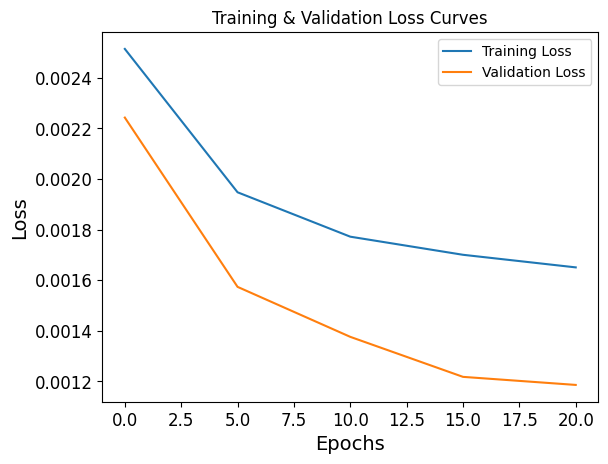

In [160]:
# Plot some of the results
plt.plot(epoch_count, train_loss_values, label="Training Loss")
plt.plot(epoch_count, valid_loss_values, label="Validation Loss")
plt.title("Training & Validation Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [182]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_score, roc_auc_score, recall_score, f1_score

class PerformancePlotter:
    def __init__(self):
        pass

    def plot_auc_curve(self, y_true, y_probs, ax=None):
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        target_fpr  = 0.05
        index = np.argmin(np.abs(fpr - target_fpr))
        recall_at_5_fpr = tpr[index]
        print(f"Recall at 5% FPR: {recall_at_5_fpr:.2f}")
        roc_auc = roc_auc_score(y_true, y_probs, average="weighted", multi_class="ovr")
        should_display = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
            should_display = True
        ax.plot(
            fpr,
            tpr,
            color="darkorange",
            lw=2,
            label=f"ROC curve (area = {roc_auc:.2f})",
        )
        ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title("Receiver Operating Characteristic")
        ax.legend(loc="lower right")
        if should_display:
            plt.show()

    def plot_precision_recall_curve(self, y_true, y_probs, ax=None):
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
        should_display = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
            should_display = True
        ax.plot(recalls, precisions, label="Precision-Recall Curve")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend(loc="best")
        ax.set_title("Precision-Recall Curve")
        if should_display:
            plt.show()

    def plot_precision_recall_f1_vs_threshold(self, y_true, y_probs, ax=None):
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        should_display = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
            should_display = True
        ax.plot(thresholds, f1_scores[:-1], "r-", label="F1-score")
        ax.plot(thresholds, precisions[:-1], "b--", label="Precision")
        ax.plot(thresholds, recalls[:-1], "g-", label="Recall")
        ax.set_xlabel("Threshold")
        ax.set_ylabel("Precision/Recall")
        ax.legend(loc="best")
        ax.set_title("Precision and Recall vs. Threshold")
        ax.grid(True)
        if should_display:
            plt.show()

    def plot_metrics(self, y_true, y_probs):
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        print(y_true)
        print(y_probs)
        self.plot_auc_curve(y_true, y_probs, ax=axs[0])
        self.plot_precision_recall_curve(y_true, y_probs, ax=axs[1])
        self.plot_precision_recall_f1_vs_threshold(y_true, y_probs, ax=axs[2])
        print(f"roc_auc_score:{roc_auc_score(y_true.numpy().astype(int), y_probs, average='macro', multi_class='ovr')}")
        print(f"precision_score:{precision_score(y_true.numpy().astype(int), y_probs, average='macro', zero_division=0)}")
        print(f"recall_score:{recall_score(y_true.numpy().astype(int), y_probs, average='macro', zero_division=0)}")
        print(f"f1_score:{f1_score(y_true.numpy().astype(int), y_probs, average='macro')}")
        
        plt.tight_layout()
        plt.show()

In [183]:
# Create a directory for models
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create a model save path
MODEL_NAME = "pytorch_model_var_1_solo.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

## Inference

With the model trained and saved, we can now predict labels for the test dataset.

In [184]:
# !pip install pyreadstat

In [185]:
import pickle 
import pandas as pd
import torch

# import Fl4Health

# class CPU_Unpickler(pickle.Unpickler):
#     def find_class(self, module, name):
#         if module == 'torch.storage' and name == '_load_from_bytes':
#             return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
#         else: return super().find_class(module, name)
    

# file_path = "../../best_model.pkl"

# with open(file_path, 'rb') as f:
#     model2 = CPU_Unpickler(f).load()


fed_avg_model =  torch.load("../../best_model_fedavg.pt")
fed_prox_model =  torch.load("../../best_model_fedprox.pt")
# central_model = torch.load("models/pytorch_model_base.pt")

In [186]:
model.eval()

all_preds_list = []
all_true_list = []

for x_test, y_test in test_loader:
    # Send data to the device
    x_test = x_test.to(device)
    y_test = y_test.type(torch.LongTensor).to(device)

    test_logits = model(x_test)
    y_pred =  (test_logits >= 0.5).to(torch.float).to(device)  # convert logits into predictions

    all_preds_list.append(y_pred.cpu().detach())
    all_true_list.append(y_test.cpu().detach())

all_preds = torch.cat(all_preds_list)
all_true = torch.cat(all_true_list)

tensor([0, 1, 0,  ..., 0, 0, 0])
tensor([0., 1., 0.,  ..., 0., 0., 0.])
Recall at 5% FPR: 0.55
roc_auc_score:0.738467967297579
precision_score:0.7783424831220123
recall_score:0.738467967297579
f1_score:0.7287179437845199


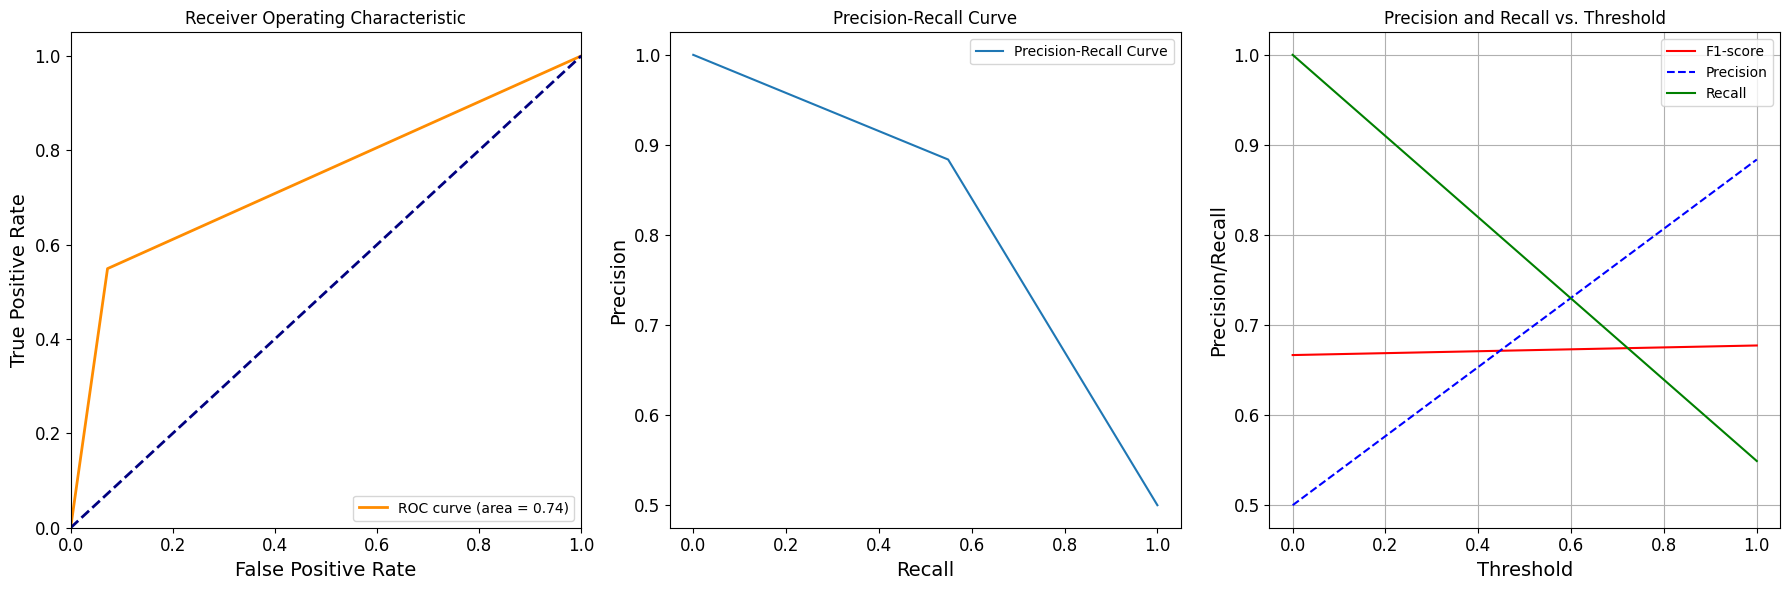

In [187]:
#### SOLO
plotter = PerformancePlotter()
plotter.plot_metrics(all_true, all_preds)

tensor([0, 1, 0,  ..., 1, 0, 1])
tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]])
Recall at 5% FPR: 0.59
roc_auc_score:0.760703569510524
precision_score:0.7941876526315967
recall_score:0.7607035695105239
f1_score:0.7539855992221365


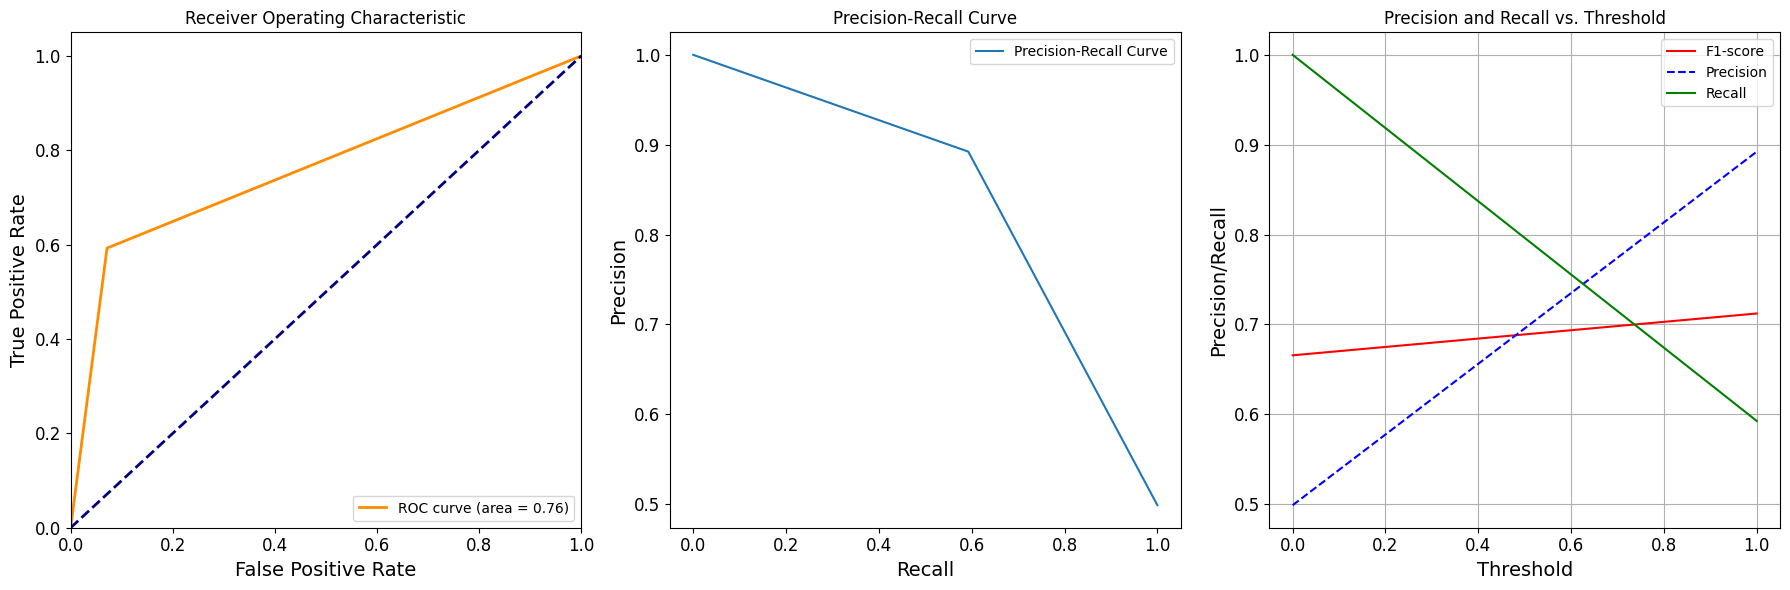

In [188]:
#### FED AVG
fed_avg_model.eval()

all_preds_list = []
all_true_list = []

for x_test, y_test in test_loader:
    # Send data to the device
    x_test = x_test.to(device)
    y_test = y_test.type(torch.LongTensor).to(device)

    test_logits = fed_avg_model(x_test)
    y_pred =  (test_logits >= 0.5).to(torch.float).to(device)  # convert logits into predictions

    all_preds_list.append(y_pred.cpu().detach())
    all_true_list.append(y_test.cpu().detach())

all_preds = torch.cat(all_preds_list)
all_true = torch.cat(all_true_list)

plotter = PerformancePlotter()
plotter.plot_metrics(all_true, all_preds) 

tensor([1, 0, 1,  ..., 0, 0, 1])
tensor([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]])
Recall at 5% FPR: 0.60
roc_auc_score:0.762774906869131
precision_score:0.7924585998363526
recall_score:0.7627749068691309
f1_score:0.7563861265745468


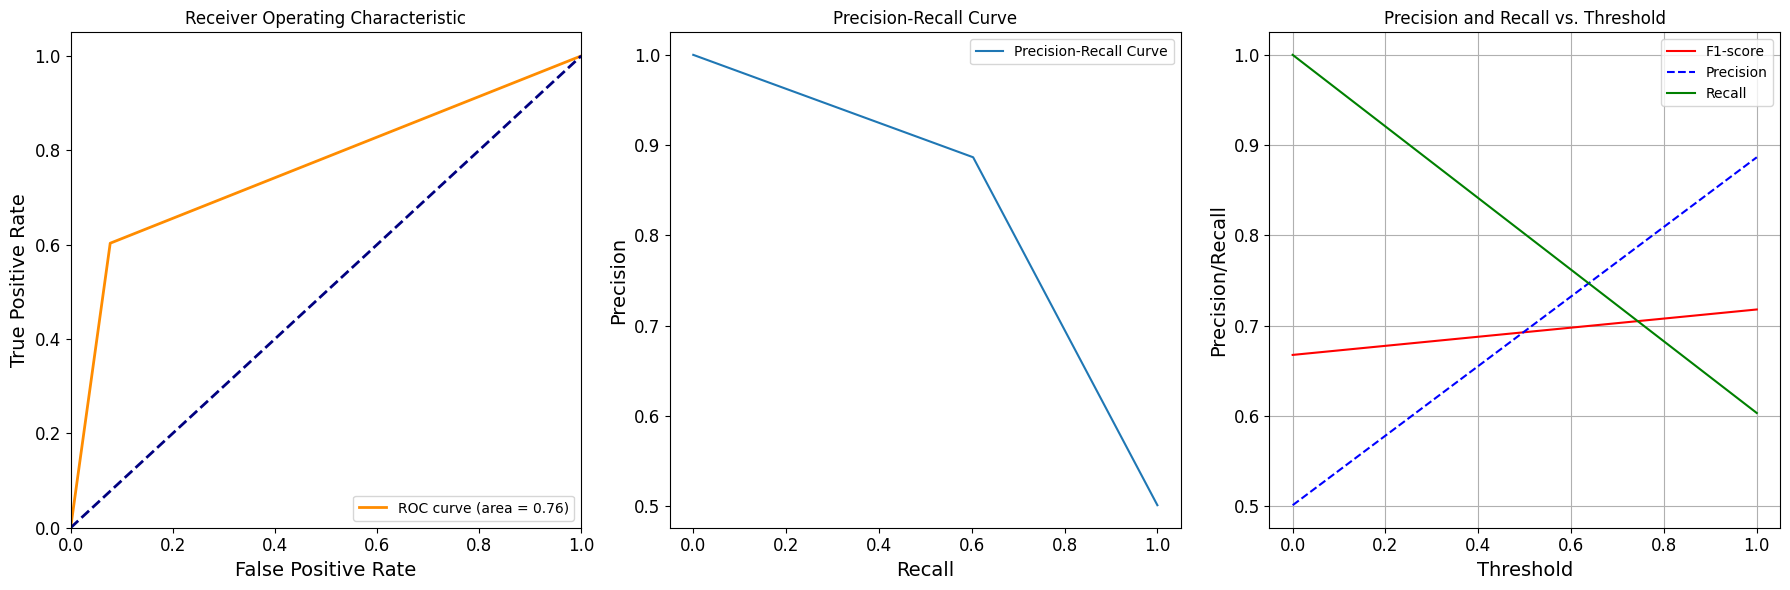

In [189]:
#### FED PROX
fed_prox_model.eval()

all_preds_list = []
all_true_list = []

for x_test, y_test in test_loader:
    # Send data to the device
    x_test = x_test.to(device)
    y_test = y_test.type(torch.LongTensor).to(device)

    test_logits = fed_prox_model(x_test)
    y_pred =  (test_logits >= 0.5).to(torch.float).to(device)  # convert logits into predictions

    all_preds_list.append(y_pred.cpu().detach())
    all_true_list.append(y_test.cpu().detach())

all_preds = torch.cat(all_preds_list)
all_true = torch.cat(all_true_list)

plotter = PerformancePlotter()
plotter.plot_metrics(all_true, all_preds) 

In [179]:
# ## CENTRAL MODEL

# central_model.eval()

# all_preds_list = []
# all_true_list = []

# for x_test, y_test in test_loader:
#     # Send data to the device
#     x_test = x_test.to(device)
#     y_test = y_test.type(torch.LongTensor).to(device)

#     test_logits = central_model(x_test)
#     y_pred =  (test_logits >= 0.5).to(torch.float).to(device)  # convert logits into predictions

#     all_preds_list.append(y_pred.cpu().detach())
#     all_true_list.append(y_test.cpu().detach())

# all_preds = torch.cat(all_preds_list)
# all_true = torch.cat(all_true_list)

# plotter = PerformancePlotter()
# plotter.plot_metrics(all_true, all_preds) 